# PS reconstruction, Gaussian beam

In [1]:
import torch
from copy import deepcopy

import lightning as L

from gpsr.diagnostics import ImageDiagnostic
from gpsr.datasets import SixDReconstructionDataset
from gpsr.modeling import GPSR6DLattice, GPSR
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator

ModuleNotFoundError: No module named 'phase_space_reconstruction'

## Import data

In [ ]:
obs_dataset = torch.load("example_data/example_datasets/reconstruction_6D.dset")

print(obs_dataset.parameters.shape, obs_dataset.observations[0].shape, obs_dataset
      .observations[1].shape)

obs_dataset.plot_data(publication_size=True);

Cheetah based version

In [3]:
p0c = 43.36e6 # reference momentum in eV/c

bins = torch.linspace(-5, 5, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

l_quad=0.11
l_tdc=0.01
f_tdc=1.3e9
phi_tdc=0.0
l_bend=0.3018
theta_on=- 20.0 * 3.14 / 180.0
l1=0.790702
l2=0.631698
l3=0.889

gpsr_lattice = GPSR6DLattice(
    l_quad,
    l_tdc,
    f_tdc,
    phi_tdc,
    l_bend,
    theta_on,
    l1,
    l2,
    l3,
    deepcopy(screen),
    deepcopy(screen),
)



## Training using pytorch lightning

In [4]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(obs_dataset, batch_size=20)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger('.', )
trainer = L.Trainer(limit_train_batches=100,max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type | Params
------------------------------------
0 | gpsr_model | GPSR | 1.1 K 
------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
C:\Users\Ryan Roussel\mambaforge\envs\phase_space_reconstruction\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\Ryan Roussel\mambaforge\envs\phase_space_reconstruction\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interva

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


In [5]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

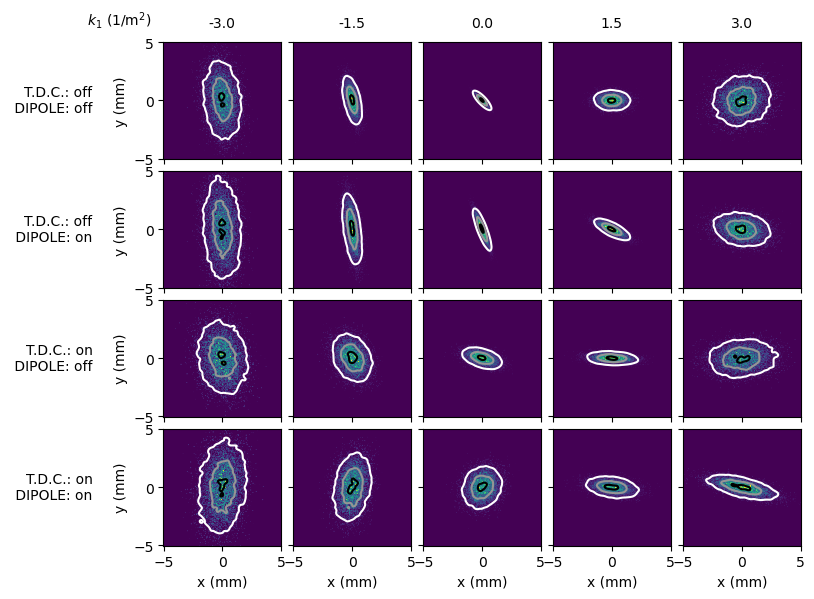

In [6]:
train_params = obs_dataset.parameters
pred = gpsr_model(train_params)[0]
pred_dataset = SixDReconstructionDataset(train_params, pred, (bins, bins))
obs_dataset.plot_data(
    publication_size=True,
    overlay_data=pred_dataset,
    overlay_kwargs={"cmap":"Greys","levels":[0.1,0.5,0.9]}
);


(<Figure size 1200x1200 with 36 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='$p_x$ (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$y$ (mm)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$p_y$ (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$tau$ (mm)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: xlabel='$x$ (mm)', ylabel='$p$ (mrad)'>,
         <Axes: xlabel='$p_x$ (mrad)'>, <Axes: xlabel='$y$ (mm)'>,
         <Axes: xlabel='$p_y$ (mrad)'>, <Axes: xlabel='$tau$ (mm)'>,
         <Axes: xlabel='$p$ (mrad)'>]], dtype=object))

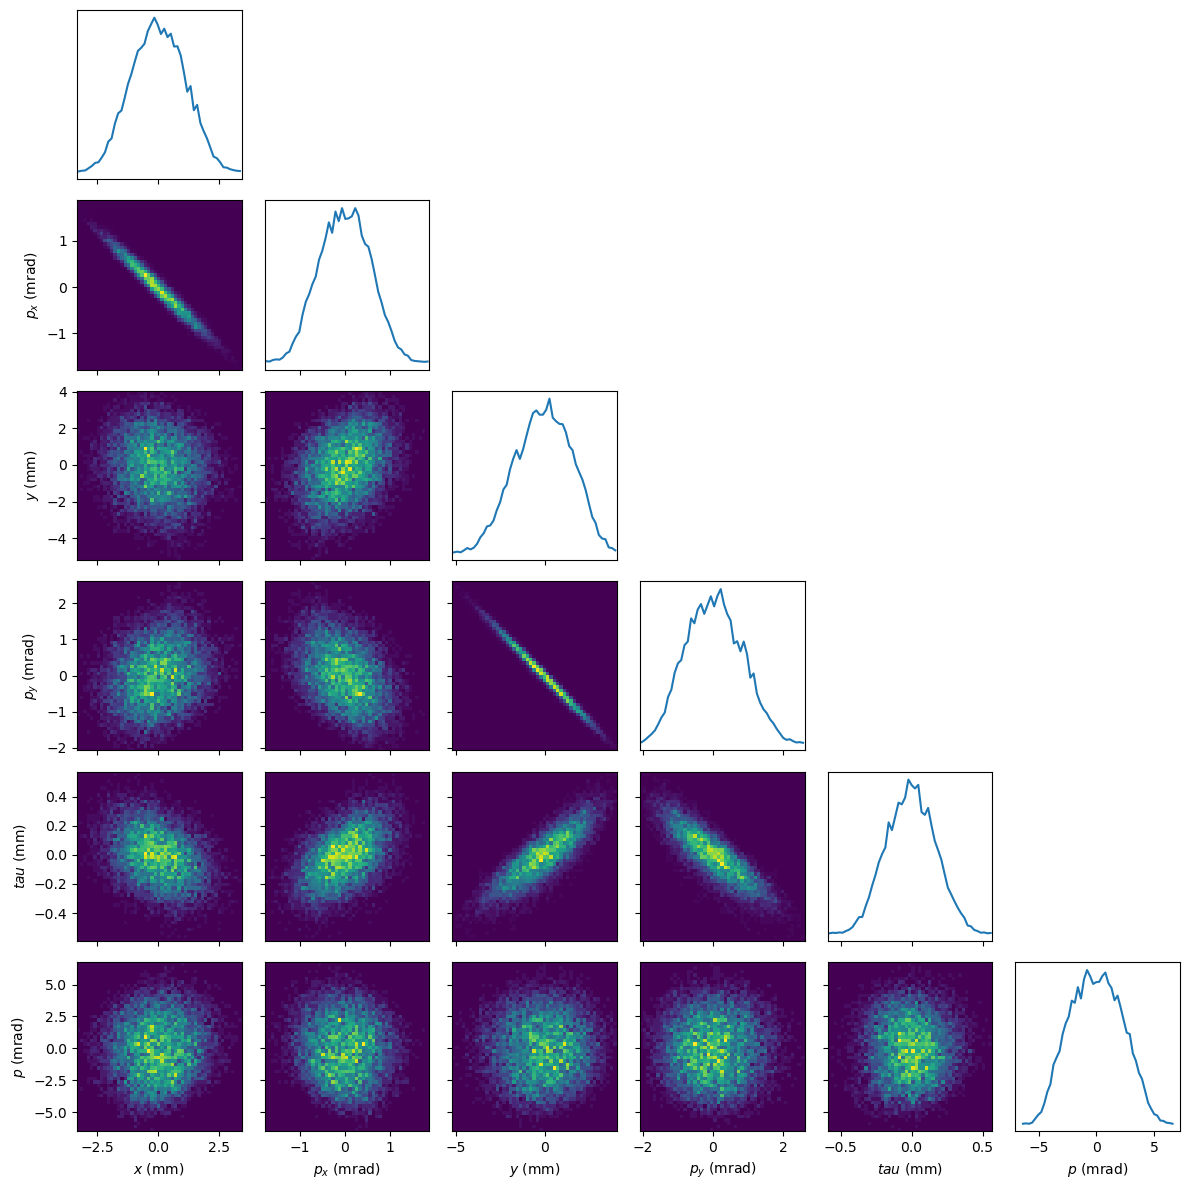

In [7]:
reconstructed_beam.plot_distribution()